# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


#### 1. Is the distribution of body temperatures normal
From the histogram, we can see the temperature distribution is close to normal distribution.

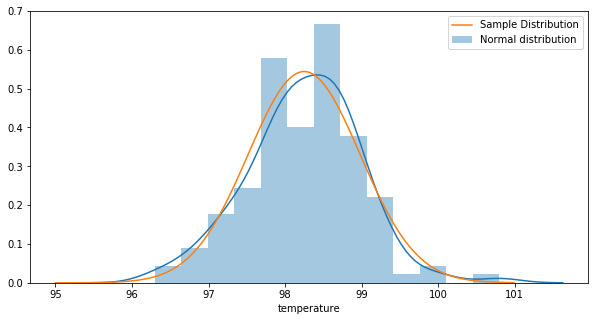

In [2]:
plt.figure(figsize = (10,5))
sns.distplot(df['temperature'])
x = np.arange(95, 101, 0.01)
mu = df['temperature'].mean()
sg = df['temperature'].std()
y = np.exp(-(x-mu)**2/(2*sg**2)) / np.sqrt(2*np.pi*sg**2)
plt.plot(x, y)
plt.legend(['Sample Distribution','Normal distribution'])
plt.show()

We can also check the KL divergence between the distribution and normal distribution with parameters mean and standard deviation estimated by the sample mean and standard deviation.

In [3]:
bins = np.arange(95,101,0.25)
dist, _ = np.histogram(df['temperature'], bins=bins)
temp = (bins[1:] + bins[:-1])/2
normal_dist = df['temperature'].mean() + df['temperature'].std() * temp
KL = stats.entropy(dist, normal_dist)
print("KL divergence:", KL)

KL divergence: 0.7315910329223548


#### 2. Is the sample size large? Are the observations independent?

Sample size = 130, this should be large enough for z-test or t-test. Usually we can assume people's body temperature/heart rate are independent of each other, if the sample is drawn randomly.

In [4]:
N = df.shape[0]
print("sample size:", N)

sample size: 130


#### 3. Is the true population mean really 98.6 degrees F?

Do bootstrap test, assuming the true population mean is 98.6 $^\circ$F, we can find the 95% confidence interval using 10000 bootstrap samples, which does not contain the observed mean: 98.25 $^\circ$F, so it is unlikely that the true population mean is 98.6 $^\circ$F.

In [5]:
def bootstrap_test(data, func, size=1):
    bs_rep = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, size=len(data))
        bs_rep[i] = func(bs_sample)
    return bs_rep

obs_mean = df['temperature'].mean()
temp_translated = df['temperature'].values - obs_mean + 98.6
bs_rep = bootstrap_test(temp_translated, np.mean, size=10000)
conf_int = np.percentile(bs_rep, [2.5, 97.5])
print("observed mean", obs_mean, "confidence inteval", conf_int)

observed mean 98.24923076923075 confidence inteval [98.47538462 98.72461538]


We are given one sample and are asked to do hypothesis on the population mean, so we should do one sample test.

The population standard deviation is unknown, so it's better to use t-test. If we do the z-test, we find the p-value is smaller, because normal distribution has a smaller tail than t-distribution, so the extreme values is less likely to happen.

In [6]:
stats.ttest_1samp(df['temperature'], 98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

In [7]:
obs_mean = df['temperature'].mean()
obs_std = df['temperature'].std()
z = (obs_mean - 98.6)/(obs_std/np.sqrt(N))
p = stats.norm.cdf(z)
print("z-test result: statistics = %f, p-value = %f"%(z,p))

z-test result: statistics = -5.454823, p-value = 0.000000


#### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

Usually z-test need sample size > 30, so here we should use t-test. But anyway, we will try do both tests for 5 times. For small samples, the p-values becomes much large in t-test. This should be more obvious in t-test, because in t-test the sample size not only affect the standard error, but also affect the degree of freedom. With small sample size (small degree of freedom), the t-distribution has a larger tail.

In [8]:
for _ in range(5):
    sample10 = df['temperature'].sample(10)
    print(stats.ttest_1samp(sample10, 98.6))

    obs_mean = sample10.mean()
    obs_std = sample10.std()
    z = (obs_mean - 98.6)/(obs_std/np.sqrt(N))
    p = stats.norm.cdf(z)
    print("z-test result: statistics = %f, p-value = %f"%(z,p))
    print('\n')

Ttest_1sampResult(statistic=-0.5351865696615391, pvalue=0.605490033230097)
z-test result: statistics = -1.929643, p-value = 0.026826


Ttest_1sampResult(statistic=-1.2270192370855353, pvalue=0.2509439253948832)
z-test result: statistics = -4.424081, p-value = 0.000005


Ttest_1sampResult(statistic=-3.42593132309539, pvalue=0.0075567020964975576)
z-test result: statistics = -12.352371, p-value = 0.000000


Ttest_1sampResult(statistic=-2.7187499999999254, pvalue=0.023656171806071147)
z-test result: statistics = -9.802593, p-value = 0.000000


Ttest_1sampResult(statistic=-1.8655483309128502, pvalue=0.09497014162051878)
z-test result: statistics = -6.726330, p-value = 0.000000




#### 5. At what temperature should we consider someone's temperature to be "abnormal"?

We can estimate the 99% confidence interval with t statistics. The confidence interval is (98.081, 98.417), so temperature < 98.081 $^\circ$F or > 98.417 $^\circ$F can be considered as "abnormal".

In [9]:
t = stats.t.ppf(1-0.005, N-1)
obs_mean = df['temperature'].mean()
obs_std = df['temperature'].std()
SE = obs_std/np.sqrt(N)
conf_int = (obs_mean - t*SE, obs_mean + t*SE)
conf_int

(98.08110824239756, 98.41735329606394)

#### 6. Is there a significant difference between males and females in normal temperature?

In this case, we want to compare two group means, both group contains 65 samples, and we check the histogram that both distributions are not two skews, so a two sample t-test would be appropriate.

The null hypothesis would be there is no significant difference between males and females temperature.

F    65
M    65
Name: gender, dtype: int64


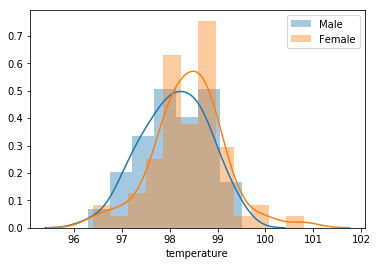

In [10]:
print(df['gender'].value_counts())
sns.distplot(df['temperature'].loc[df['gender']=='M'])
sns.distplot(df['temperature'].loc[df['gender']=='F'])
plt.legend(('Male','Female'))
plt.show()

The p-value is ~0.0239, which is means with 5% statistical significant, we can reject the null hypothesis, and conclude that there is a significant difference between males and females temperature.

In [11]:
temp_M = df['temperature'].loc[df['gender']=='M']
temp_F = df['temperature'].loc[df['gender']=='F']

stats.ttest_ind(temp_M, temp_F)

Ttest_indResult(statistic=-2.2854345381656103, pvalue=0.02393188312239561)